In this notebook we take the census data and obtain a few key details for each SA1 region, storing each SA1 region as a JSON file. We'll start with just density, zoning, and finance information.

- density info from G01A (Total Persons)
- zoning from the EPI zone WMS
- finance from G02 (median household income)

What else might we want?

In [82]:
import pandas, shapefile
from tqdm import tqdm_notebook as tqdm
import numpy
from matplotlib import pyplot as plt
import json

In [83]:
g02 = pandas.read_csv(
    '../2016 Census GCP Statistical Area 1 for NSW/'
    '/2016Census_G02_NSW_SA1.csv').set_index('SA1_7DIGITCODE_2016')
g01 = pandas.read_csv(
    '../2016 Census GCP Statistical Area 1 for NSW/'
    '/2016Census_G01_NSW_SA1.csv').set_index('SA1_7DIGITCODE_2016')
# G14 [religion]
g14 = pandas.read_csv(
    '../2016 Census GCP Statistical Area 1 for NSW/'
    '/2016Census_G14_NSW_SA1.csv').set_index('SA1_7DIGITCODE_2016')
# G43 [unemployment rate]
g43 = pandas.read_csv(
    '../2016 Census GCP Statistical Area 1 for NSW/'
    '/2016Census_G43B_NSW_SA1.csv').set_index('SA1_7DIGITCODE_2016')
# G33 [% renting]
g33 = pandas.read_csv(
    '../2016 Census GCP Statistical Area 1 for NSW/'
    '/2016Census_G33_NSW_SA1.csv').set_index('SA1_7DIGITCODE_2016')

# G02 [median rent weekly]
median_weekly_rent = pandas.read_csv(
    '../2016 Census GCP Statistical Area 1 for NSW/'
    '/2016Census_G02_NSW_SA1.csv').set_index('SA1_7DIGITCODE_2016')


In [84]:
list(g02.columns)

['Median_age_persons',
 'Median_mortgage_repay_monthly',
 'Median_tot_prsnl_inc_weekly',
 'Median_rent_weekly',
 'Median_tot_fam_inc_weekly',
 'Average_num_psns_per_bedroom',
 'Median_tot_hhd_inc_weekly',
 'Average_household_size']

In [85]:
with open('../zone-info-sydney.json') as f:
    zoning = json.load(f)

In [86]:
with open('../sa1_seven_to_sixteen.json') as f:
    sa1_seven_to_sixteen = json.load(f)

In [87]:
sa1_sixteen_to_seven = {v: k for k, v in sa1_seven_to_sixteen.items()}

In [88]:
zoning = {sa1_sixteen_to_seven[k]: v for k, v in zoning.items()}

In [89]:
pops = g01.Tot_P_P

In [90]:
finance = g02.Median_tot_hhd_inc_weekly

In [91]:
# religio
religion = 1 - (g14.SB_OSB_NRA_Tot_P / (g14.Tot_P - g14.Religious_affiliation_ns_P))

In [92]:
# unemployment %
unemployed_rate = g43.P_Tot_Unemp_Tot / g43.P_Tot_Tot

In [93]:
# rental rate %

rental_rate = g33.R_Tot_Total / g33.Total_Total

In [94]:
median_rent = g02.Median_rent_weekly

In [95]:
shape = shapefile.Reader('../shapesnsw/MB_2016_NSW')

In [96]:
sa2_to_name = {}
sa2_to_coords = {}
for sr in tqdm(shape.shapeRecords()):
    sa2, name = sr.record.SA1_7DIG16, sr.record.SA2_NAME16
    sa2_to_name[int(sa2)] = name
    if len(sr.shape.points) > 0:
        sa2_to_coords[sa2] = numpy.mean(sr.shape.points, axis=0)

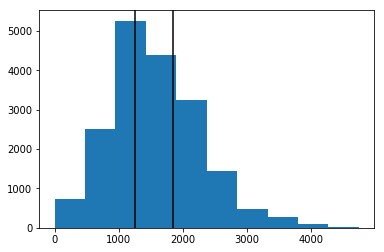

In [97]:
plt.hist(finance)
finance_pc = numpy.percentile(finance[finance > 0], [33, 66])
for p in finance_pc:
    plt.axvline(p, color='k')
finance_pc = numpy.append(finance_pc, 100000)

In [101]:
finance_pc

array([  1261.91,   1843.  , 100000.  ])

In [98]:
deets = []
for sa2, pop, fin, religious in zip(g01.index, pops, finance, religion):
    name = sa2_to_name[sa2]
    if str(sa2) not in zoning:
        continue
    deets.append(dict(
        name=name,
        sa2=str(sa2),
        lon=sa2_to_coords[str(sa2)][0],
        lat=sa2_to_coords[str(sa2)][1],
        zoning=zoning[str(sa2)],
        population=pop,
        income=fin,
        income_level=int((fin < finance_pc).argmax() + 1),
        religious=religious,
        unemployment=unemployed_rate[sa2],
        rental_rate=rental_rate.loc[sa2],
        median_rent=int(median_rent.loc[sa2]),
    ))


In [99]:
with open('sa2_regions.json', 'w') as f:
    json.dump(deets, f)

In [100]:
deets[0]

{'name': 'Blacktown (East) - Kings Park',
 'sa2': '1130301',
 'lon': 150.92304244455565,
 'lat': -33.75371430466663,
 'zoning': {'R': 10000},
 'population': 216,
 'income': 1875,
 'income_level': 3,
 'religious': 0.8221153846153846,
 'unemployment': 0.07142857142857142,
 'rental_rate': 0.38028169014084506,
 'median_rent': 400}